In [1]:
!pip3 install pyclustering prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer
from utilities import *

In [50]:
!cp './utilities.py' '/content/drive/MyDrive/code/utilities.py'

In [3]:
try:
    from google.colab import drive

    drive.mount('/content/drive')

    DATA_PATH = '/content/drive/Shareddrives/DM_tweets/data/'
    !cp '/content/drive/MyDrive/code/utilities.py' '.'
except ModuleNotFoundError:
    try:
        DATA_PATH = 'G:/Shared drives/DM_tweets/data/'
        os.mkdir(DATA_PATH)
    except FileNotFoundError:
        DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [5]:
def get_metrics(data_scaled, labels, print_out=True):
    silohuette = metrics.silhouette_score(data_scaled, labels)
    DBscore = metrics.davies_bouldin_score(data_scaled, labels)
    if print_out:
        print(f"Silouhette score: {silohuette}")  # [-1, 1] Good when near 1
        print(f"Davies Bouldin score: {DBscore}")  # Good when near 0
    else:
        return silohuette, DBscore


In [6]:
def sse(df, labels):
    sum = 0
    for label in np.unique(labels):
        mean = df[labels==label].mean().values
        row_sums = df.apply(lambda row: np.linalg.norm(row.values - mean)**2,axis=1).sum()
        print(row_sums)
        sum += np.sum(row_sums)
    return sum

In [7]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None, filename=None, filter=None):
    #cent = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(df[attr1], df[attr2], c=c_labels)

    if filter:
        df = df.loc[filter]
        c_labels = c_labels[filter]

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')

    plt.tick_params(axis='both', which='major')

    plt.savefig(filename)


In [8]:
def plots(df, labels, path=None, centroids=None, attributes=None):
  if attributes is None:
    attributes = df.columns

  try:
      os.mkdir(path)
  except FileExistsError:
      pass

  # Line plot
  plt.figure(figsize=(50, 5))
  for label in np.unique(labels):
    if centroids is None:
      cent = df[attributes][labels == label].median()
    else:
      cent = centroids[label]
    plt.plot(cent, label="Cluster %s" % label)
  plt.tick_params(axis='both', which='major')
  plt.xticks(range(0, len(df[attributes].columns)), df[attributes].columns)
  plt.legend()
  if path is not None:
    plt.savefig(path + "/landscape.png")
  else:
      plt.show()

  # Radar plot
  N = len(attributes)

  plt.figure(figsize=(8, 8))
  for label in np.unique(labels):
      angles = [n / float(N) * 2 * math.pi for n in range(N)]
      if centroids is None:
        values = df[attributes].loc[np.where(labels == label)].median().tolist()
      else:
        values = centroids[label].tolist()
      values += values[:1]
      angles += angles[:1]

      ax = plt.subplot(polar=True)
      plt.xticks(angles[:-1], attributes)
      ax.plot(angles, values, linewidth=2)
      ax.fill(angles, values, 'b', alpha=0.1)

  plt.savefig(path + "/radar.png")

  # Plot w.r.t. languages
  lang_ct = pd.crosstab(labels, df['lang'])

  fig, ax = plt.subplots(figsize=(46, 15))
  lang_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('lang')
  plt.yscale('log')
  plt.legend(prop={'size': 15})
  plt.savefig(path + "/lang_characterization.png")

  # Plot w.r.t. bots
  bot_ct = pd.crosstab(labels, df['bot'])

  fig, ax = plt.subplots(figsize=(46, 15))  # Sample figsize in inches
  #plt.figure(figsize=(10,25))
  bot_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('bot')
  plt.legend(prop={'size': 30})
  plt.savefig(path + "/bot_characterization.png")


In [9]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          138156 non-null  float64
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

In [10]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [11]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                11508 non-null  object 
 1   name                              11507 non-null  object 
 2   lang                              11508 non-null  object 
 3   bot                               11508 non-null  int64  
 4   user_subscription                 11508 non-null  object 
 5   statuses_count                    11508 non-null  float64
 6   user_subscription_in_secs         11508 non-null  int64  
 7   user_id                           11504 non-null  object 
 8   n_tweets                          11504 non-null  float64
 9   2012_tweets                       11504 non-null  float64
 10  2013_tweets                       11504 non-null  float64
 11  2014_tweets                       11504 non-null  float64
 12  2015

Drop categorical columns

In [12]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'user_subscription', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

We try to understand which attributes should be transformed in log scale by analyzing the boxplots

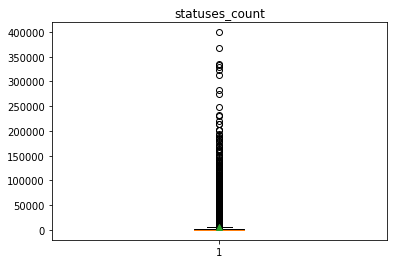

In [13]:
plot_boxplot(df_merge, 'statuses_count')

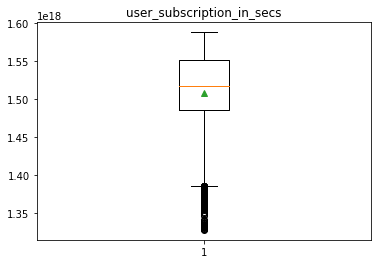

In [14]:
plot_boxplot(df_merge, 'user_subscription_in_secs')

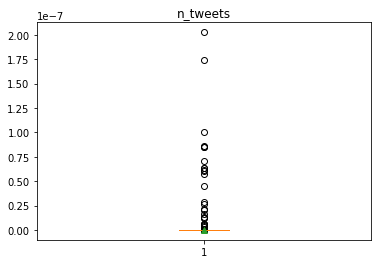

In [15]:
plot_boxplot(df_merge, 'n_tweets')

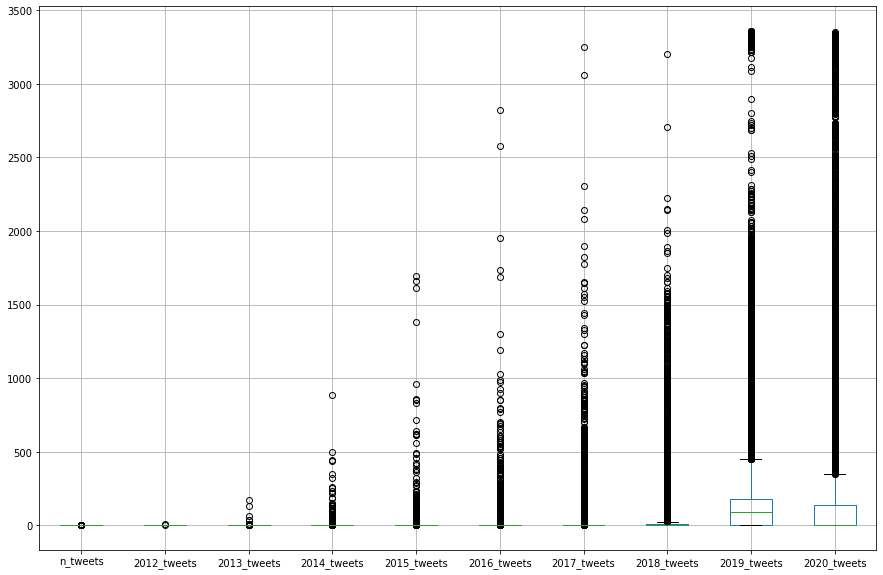

In [16]:
plt.figure(figsize=(15, 10))
df_merge.boxplot([attr for attr in df_merge.columns if '_tweets' in attr])

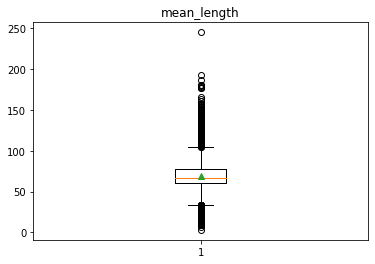

In [18]:
plot_boxplot(df_merge, 'mean_length')

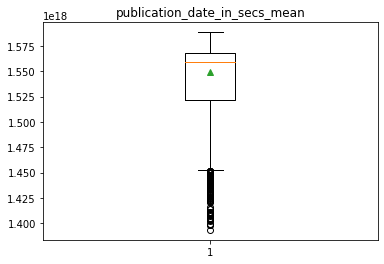

In [19]:
plot_boxplot(df_merge, 'publication_date_in_secs_mean')

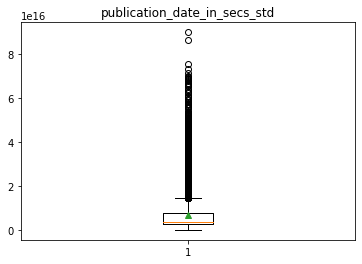

In [20]:
plot_boxplot(df_merge, 'publication_date_in_secs_std')

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


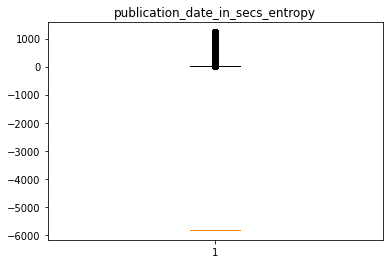

In [21]:
plot_boxplot(df_merge, 'publication_date_in_secs_entropy')

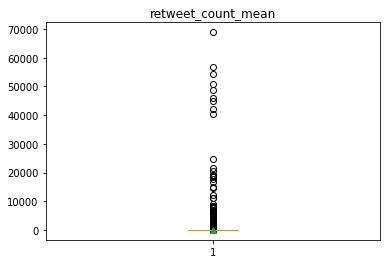

In [29]:
plot_boxplot(df_merge, 'retweet_count_mean')

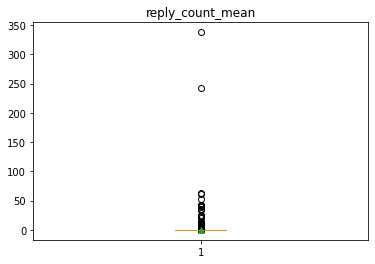

In [30]:
plot_boxplot(df_merge, 'reply_count_mean')

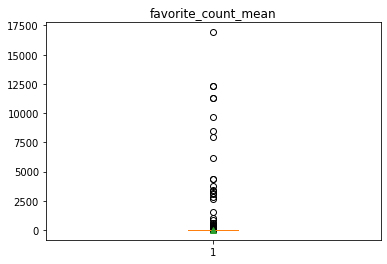

In [31]:
plot_boxplot(df_merge, 'favorite_count_mean')

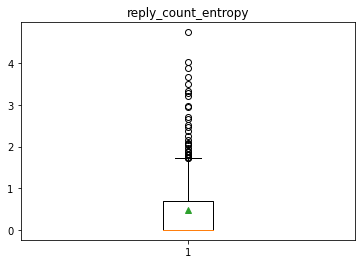

In [32]:
plot_boxplot(df_merge, 'reply_count_entropy')

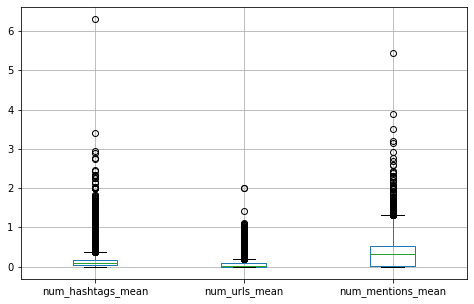

In [37]:
plt.figure(figsize=(8, 5))
df_merge.boxplot([attr for attr in df_merge.columns if 'num' in attr])

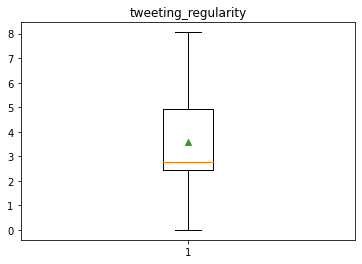

In [39]:
plot_boxplot(df_merge, 'tweeting_regularity')

In [ ]:
# To understand which attribute should be transformed in log scale
not_log = non_numeric_attributes + ['user_subscription_in_secs', 'mean_length', 'num_hashtags_mean', 'num_urls_mean', 'num_mentions_mean', 'reply_count_entropy','publication_date_in_secs_mean']


In [ ]:
# Select values to log
df_merge_log = df_merge[~not_log]

# Replace NaN values in variance with 0
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_log = df_merge_log.fillna(value=0)

# Normalization of values

In [ ]:
def to_log(df, attr):
    df[attr] = np.log(df[attr].values)
    df[attr] = df[attr].replace(-np.inf, 0)
    df[attr] = df[attr].fillna(value=0)
    return df[attr]

In [ ]:
for attr in numeric_attributes:
    df_merge_log[attr] = to_log(df_merge_log, attr)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_24992\1059147254.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)


It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [ ]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_log.columns:
    table.add_row([attr, df_merge_log[attr].min(), df_merge_log[attr].max()])
print(table)

+---------------------+---------------------+--------------------+
|         attr        |         min         |        max         |
+---------------------+---------------------+--------------------+
|    statuses_count   |         0.0         | 12.898106706802647 |
|   created_at_conv   |  41.72973140916386  | 41.90866321880304  |
|     2012_tweets     |         0.0         | 1.9459101490553132 |
|     2013_tweets     |         0.0         | 5.1298987149230735 |
|     2014_tweets     |         0.0         | 6.785587645007929  |
|     2015_tweets     |         0.0         | 7.436617265234227  |
|     2016_tweets     |         0.0         | 7.945909598613133  |
|     2017_tweets     |         0.0         | 8.086410275323782  |
|     2018_tweets     |         0.0         |  8.07153089355666  |
|     2019_tweets     |         0.0         |  8.11969625295725  |
|     2020_tweets     |         0.0         | 8.116715624819111  |
|     mean_length     |         0.0         | 5.50125821054472

In [ ]:
# Normalizzare i valori in log
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)

In [ ]:
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [ ]:
df_merge_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  float64
 2   2012_tweets          11508 non-null  float64
 3   2013_tweets          11508 non-null  float64
 4   2014_tweets          11508 non-null  float64
 5   2015_tweets          11508 non-null  float64
 6   2016_tweets          11508 non-null  float64
 7   2017_tweets          11508 non-null  float64
 8   2018_tweets          11508 non-null  float64
 9   2019_tweets          11508 non-null  float64
 10  2020_tweets          11508 non-null  float64
 11  mean_length          11508 non-null  float64
 12  retweets_count_mean  11508 non-null  float64
 13  retweets_count_std   11508 non-null  float64
 14  reply_count_mean     11508 non-null  float64
 15  favorite_count_mean  11508 non-null 

# DB Scan

In [ ]:
dist = pdist(df_merge_scaled[numeric_attributes], 'euclidean')
dist_matrix = squareform(dist)

First we compute the distance matrix to choose the epsilon parameter.
We choose quite a high k since we have a considerably high amount of samples and high dimensionality

In [ ]:
distances = list()
k = 20
for d in dist_matrix:
    index_kth_distance = np.argsort(d)[k]
    distances.append(d[index_kth_distance])

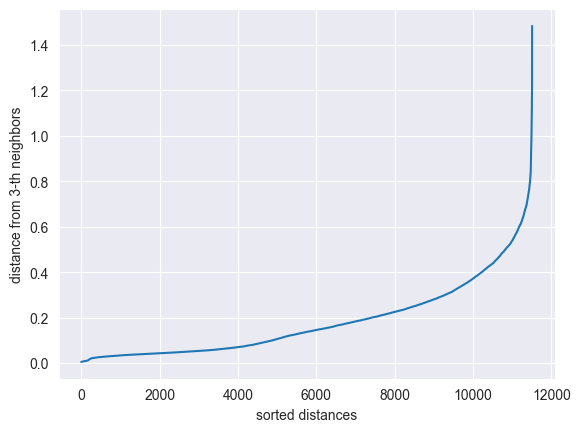

In [ ]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')

plt.savefig('dbscan/distances_curve.png')

The knee of the curve is around 0.3, so values around this point will be investigated. Interstingle, our curve bens in the 0.1 neighborhood, hence also this zone is worth investigating.

In [ ]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+-------+----------------------+--------------------+------------+
|  eps  |      silohuette      |      DB score      | n clusters |
+-------+----------------------+--------------------+------------+
| 0.075 | 0.031832867633961426 | 1.1927753662057188 |     15     |
|  0.1  | 0.01661654757792196  | 1.175406425265947  |     14     |
| 0.125 | 0.03224697925550827  | 1.1385857128930228 |     17     |
|  0.15 | 0.09398389940005945  | 1.1591983441686167 |     19     |
| 0.175 | 0.15879096562752237  | 1.198363946407331  |     22     |
|  0.2  | 0.20566631538685068  | 1.2442391272237852 |     21     |
| 0.225 | 0.25786413373686334  | 1.2604020173762571 |     19     |
|  0.25 |  0.2814716425764648  | 1.2471672071922577 |     20     |
| 0.275 | 0.32222730797958327  | 1.2787489756492436 |     18     |
|  0.3  |  0.3472954412682288  | 1.3206866042381893 |     13     |
| 0.325 | 0.35580715921775236  | 1.325318788556183  |     15     |
+-------+----------------------+--------------------+---------

The zone around 0.3 seems the more promising.

In [ ]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.28, 0.29, 0.3, 0.31]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+------+---------------------+--------------------+------------+
| eps  |      silohuette     |      DB score      | n clusters |
+------+---------------------+--------------------+------------+
| 0.28 | 0.32833145274198816 | 1.2873508147035169 |     17     |
| 0.29 |  0.3613292551922904 | 1.2993128402981362 |     14     |
| 0.3  |  0.3472954412682288 | 1.3206866042381893 |     13     |
| 0.31 |  0.3032304692105724 | 1.3158455643050988 |     14     |
+------+---------------------+--------------------+------------+


In [ ]:
dbscan = DBSCAN(eps=0.29, min_samples=42)
clusters = dbscan.fit(df_merge_scaled[numeric_attributes])

In [ ]:
try:
  os.mkdir('dbscan')
except:
  pass

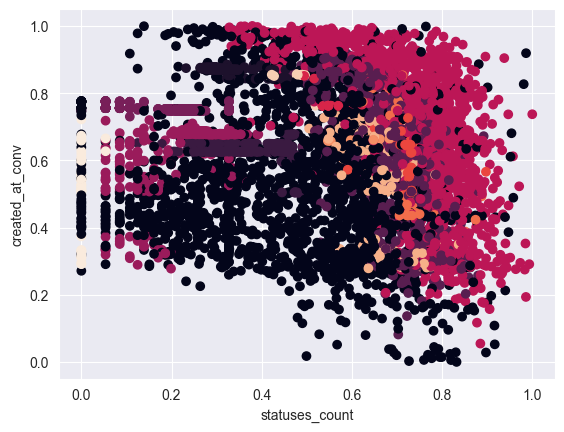

In [ ]:
plt.ylabel('user_subscription_in_secs')
plt.xlabel('statuses_count')
scatterplot(df_merge_scaled, 'statuses_count', 'user_subscription_in_secs', clusters.labels_, filename="dbscan/scatter.png")

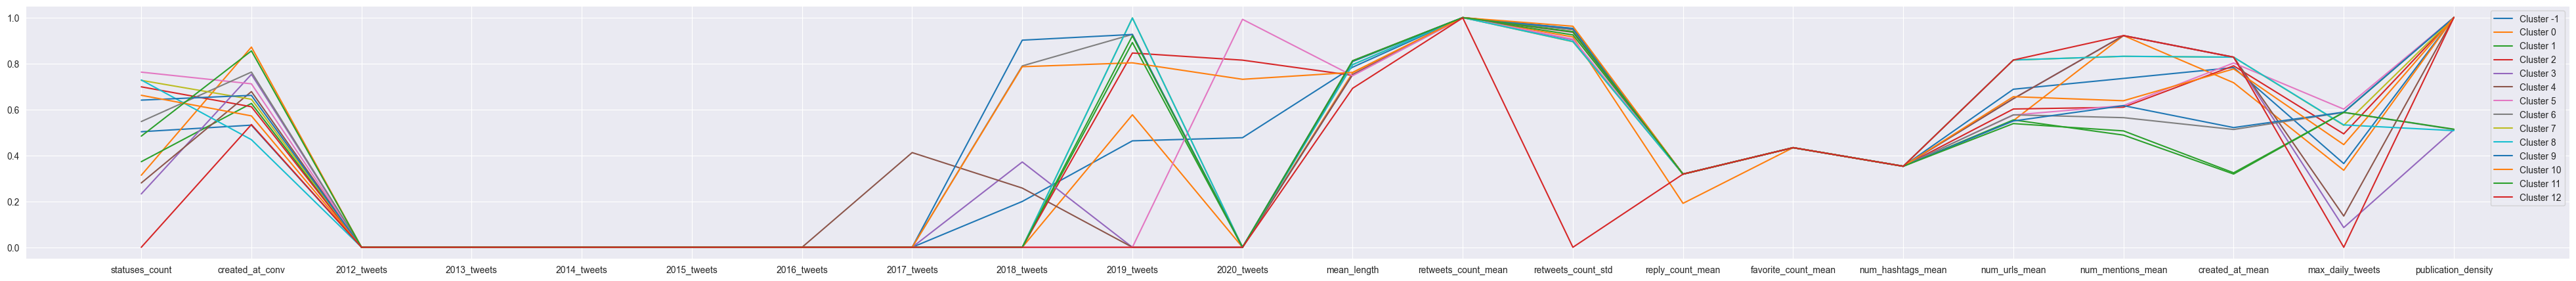

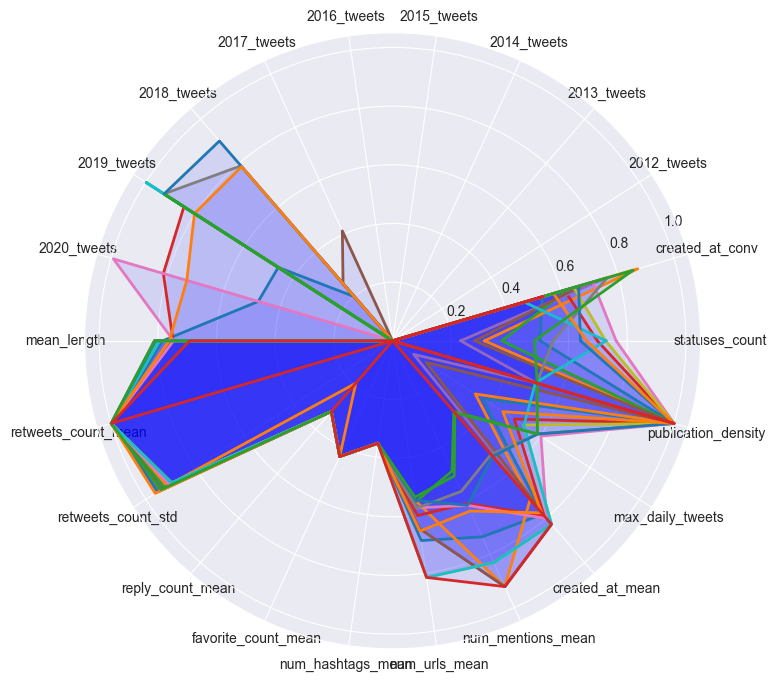

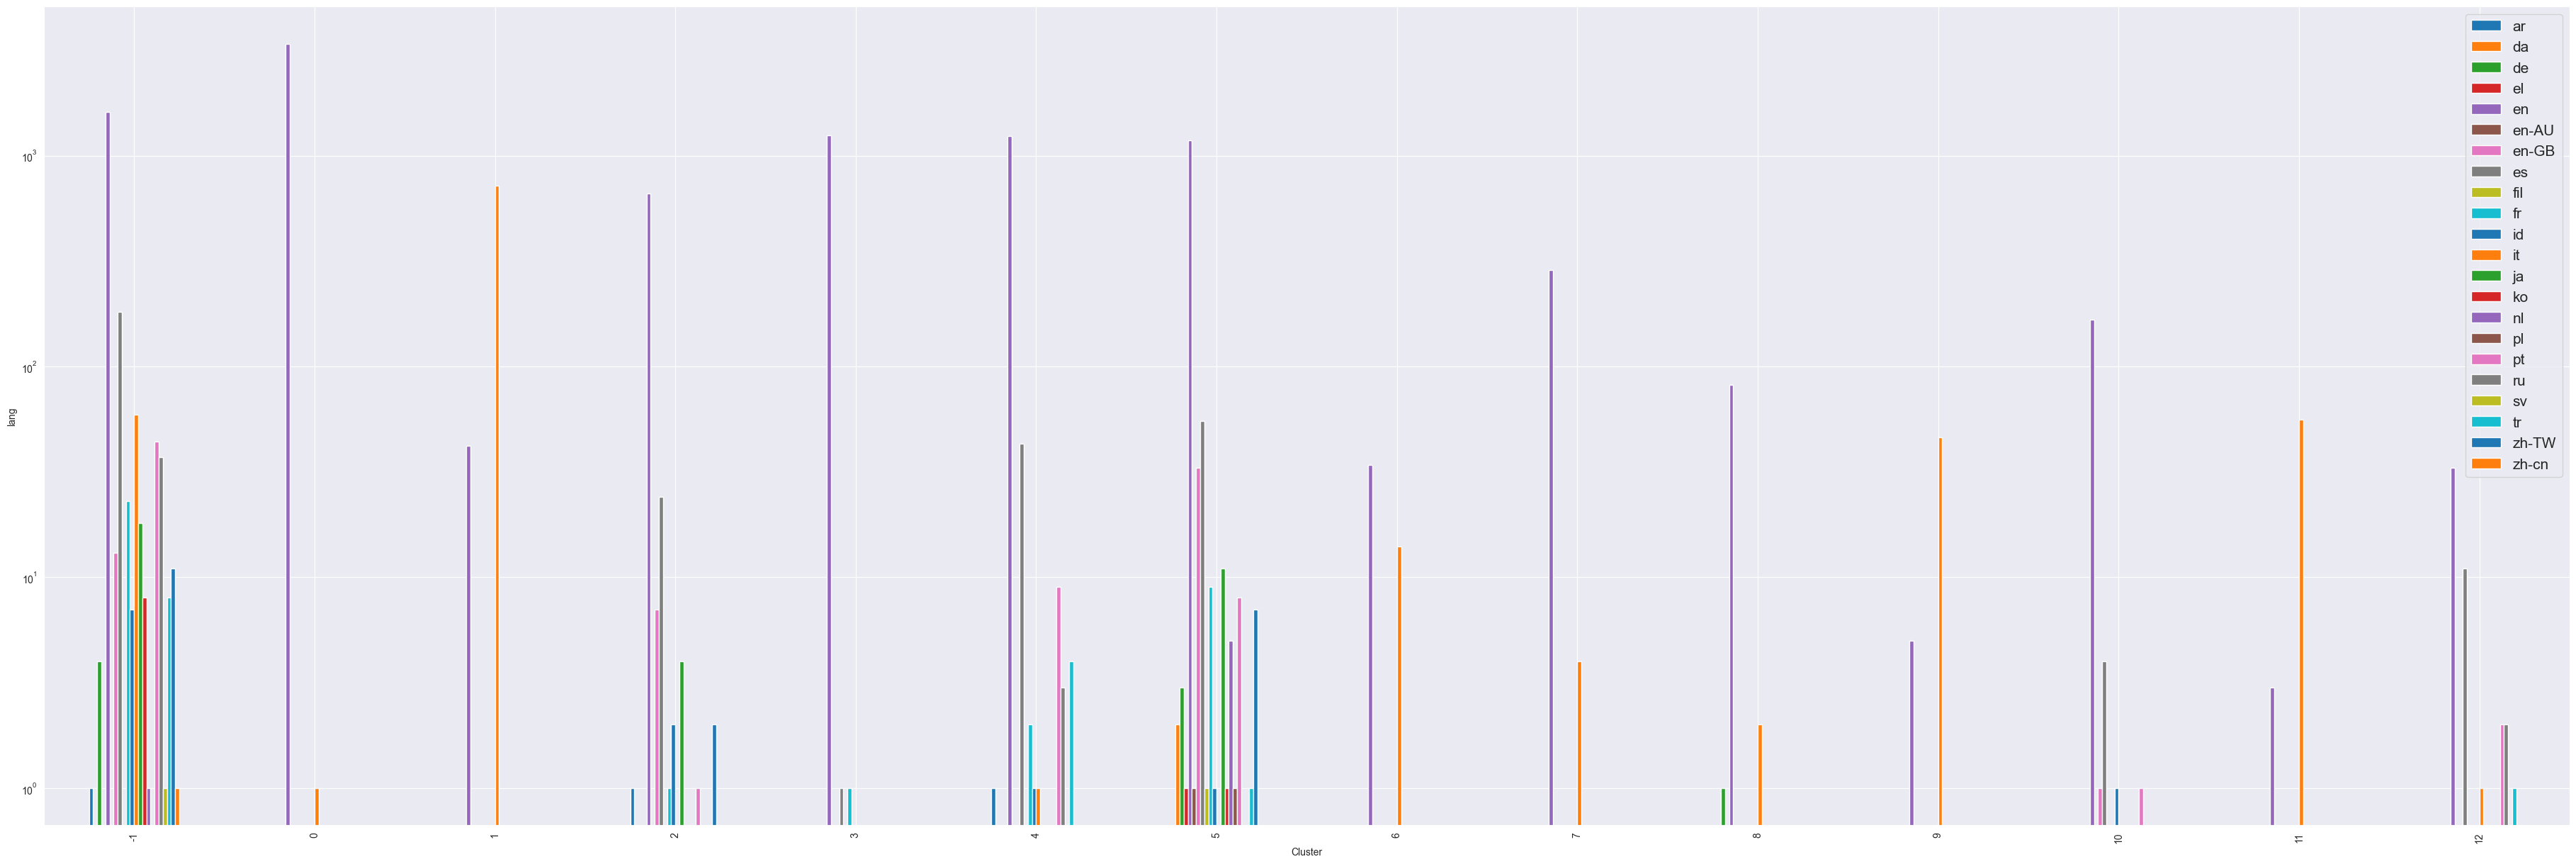

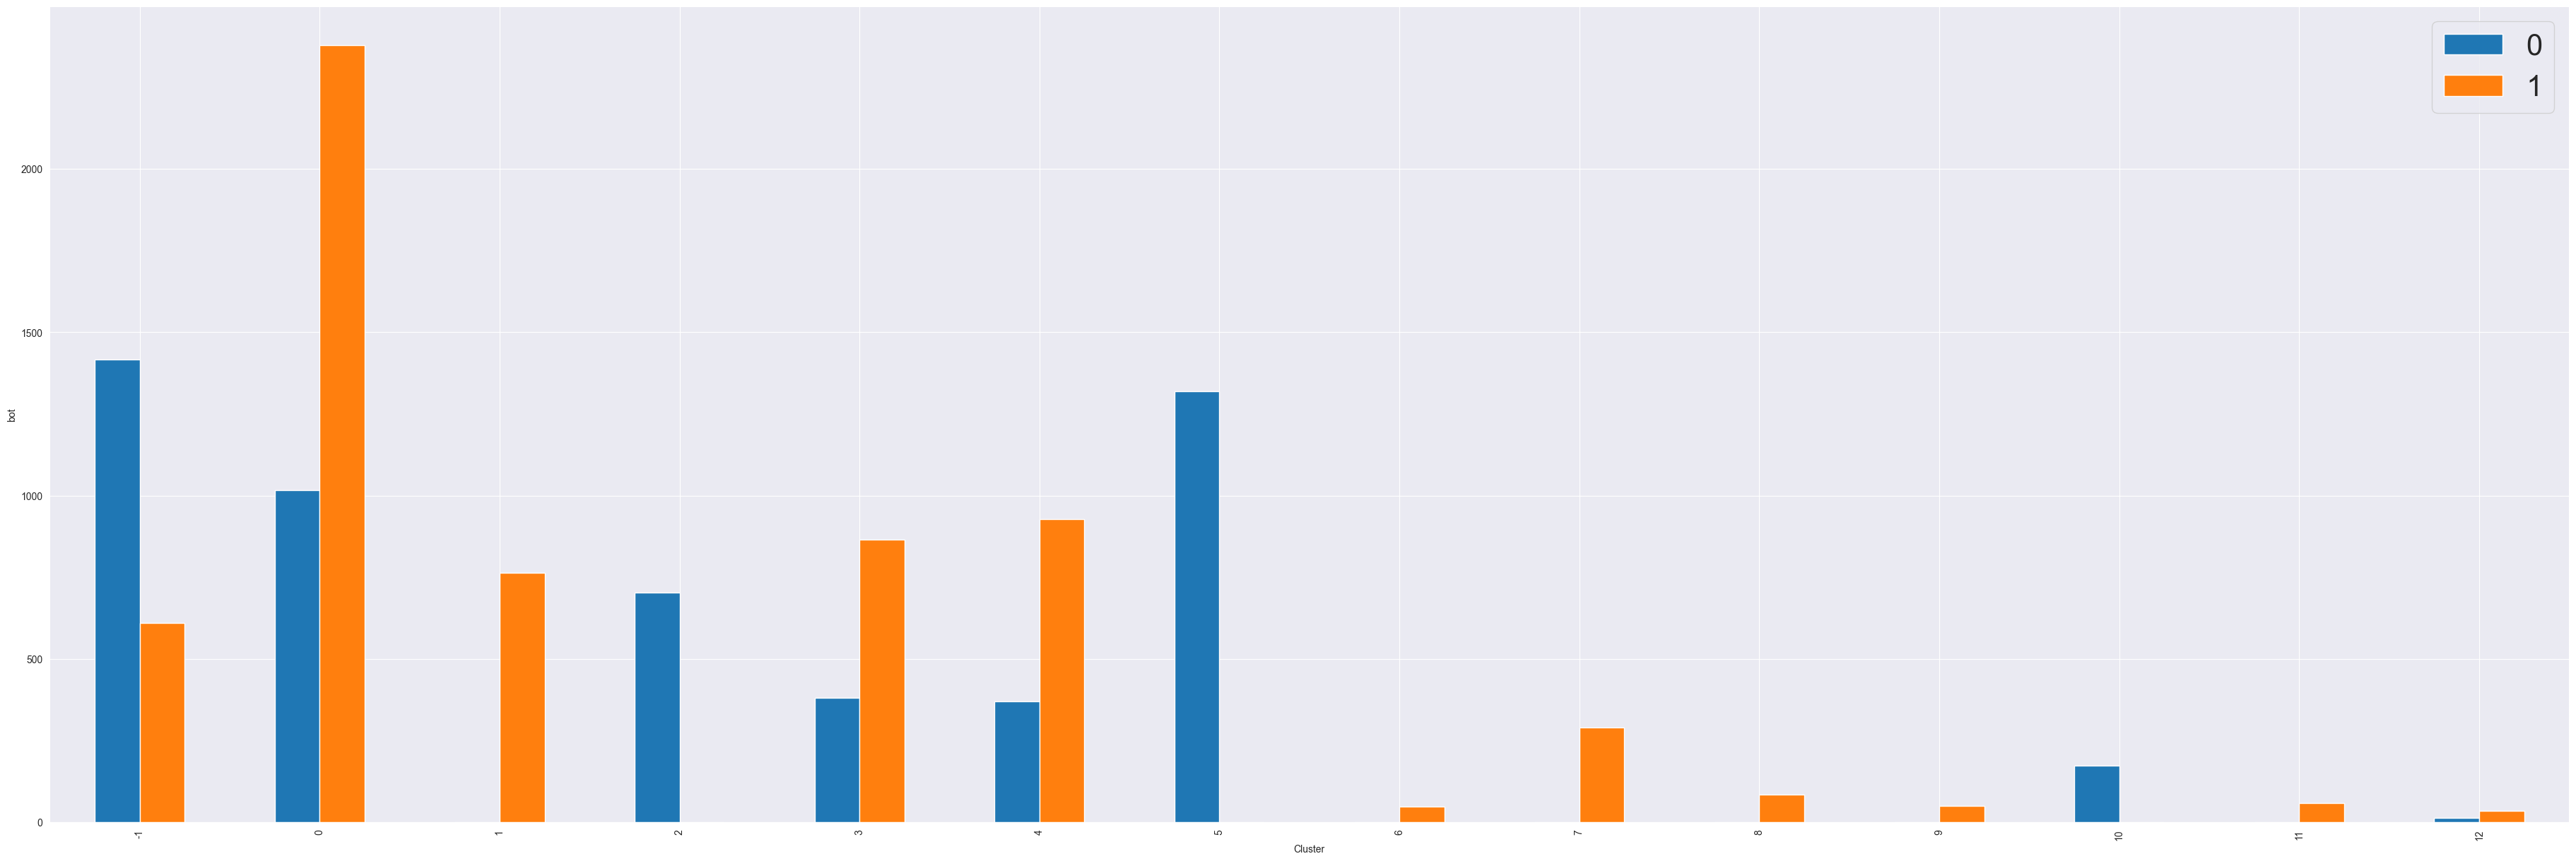

In [ ]:
plots(df_merge_scaled, clusters.labels_, path="dbscan", attributes=numeric_attributes)

In [ ]:
df_denoised = df_merge_scaled[clusters.labels_!=-1]

# KMeans

In [ ]:
try:
  os.mkdir('kmeans')
except:
  pass

K means is run in two ways: with the complete set of users and removing the samples identified as noisy by DBscan

In [ ]:
def find_optimal_k(df, max_k=40):
    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(df)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

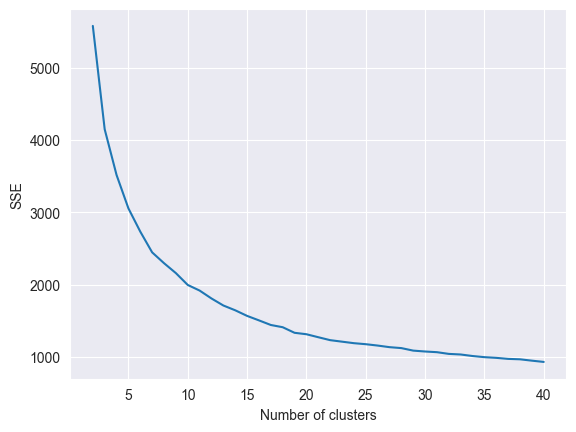

In [ ]:
find_optimal_k(df_merge_scaled[numeric_attributes])

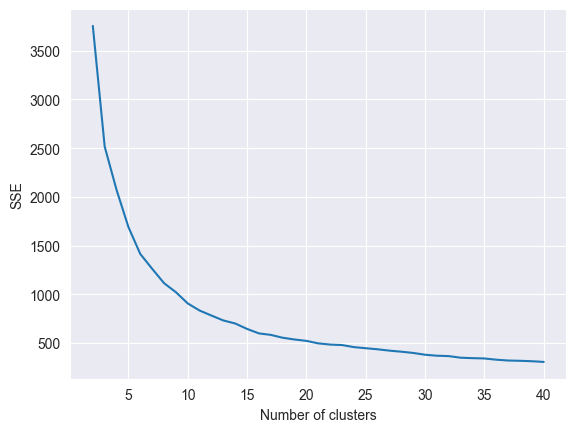

In [ ]:
find_optimal_k(df_denoised[numeric_attributes])

The optimal number of clusters seems to be around 10.

In [ ]:
def kmeans_analysis(df, k, n_init=20, max_iter=300, out_dir=None, combinations=False):
    try:
        os.mkdir(out_dir)
    except FileExistsError:
        pass

    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(df[numeric_attributes])
    cent = kmeans.cluster_centers_

    print(f'SSE:', kmeans.inertia_)
    print(f'mySSE:', sse(df[numeric_attributes], kmeans.labels_))
    get_metrics(df[numeric_attributes], kmeans.labels_)

    if combinations:
        try:
            os.mkdir(os.path.join(out_dir, 'combinations'))
        except FileExistsError:
            pass
        combs = combinations(df[numeric_attributes].columns, 2)
        os.mkdir('kmeans')
        os.mkdir('kmeans/log_denoised')
        for comb in combs:
            plt.ylabel(comb[1])
            plt.xlabel(comb[0])
            print(*comb)
            scatterplot(df, *comb, kmeans.labels_, centroids=cent,
                        filename=os.path.join(out_dir, 'combinations', f"scatterplot_{comb[1]}_{comb[0]}.png"))
    else:
        scatterplot(df, 'user_subscription_in_secs', 'statuses_count', kmeans.labels_,
                    centroids=cent, filename=os.path.join(out_dir, "clusters"))

    plots(df, kmeans.labels_, path = out_dir, centroids = cent, attributes=numeric_attributes)

SSE: 2003.84076020297
15681.447899040453
10255.049846900893
17339.645521130697
19491.159440255848
12284.936111886342
15042.39902278484
13283.359842358112
14435.806982620199
10989.192112424724
14948.259848127393
mySSE: 143751.2566275295
Silouhette score: 0.4188819078936149
Davies Bouldin score: 1.1566202591158339


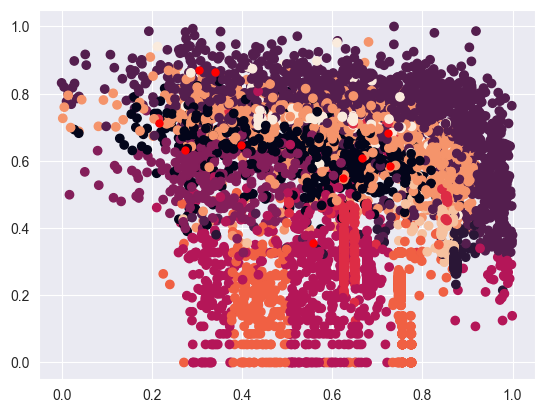

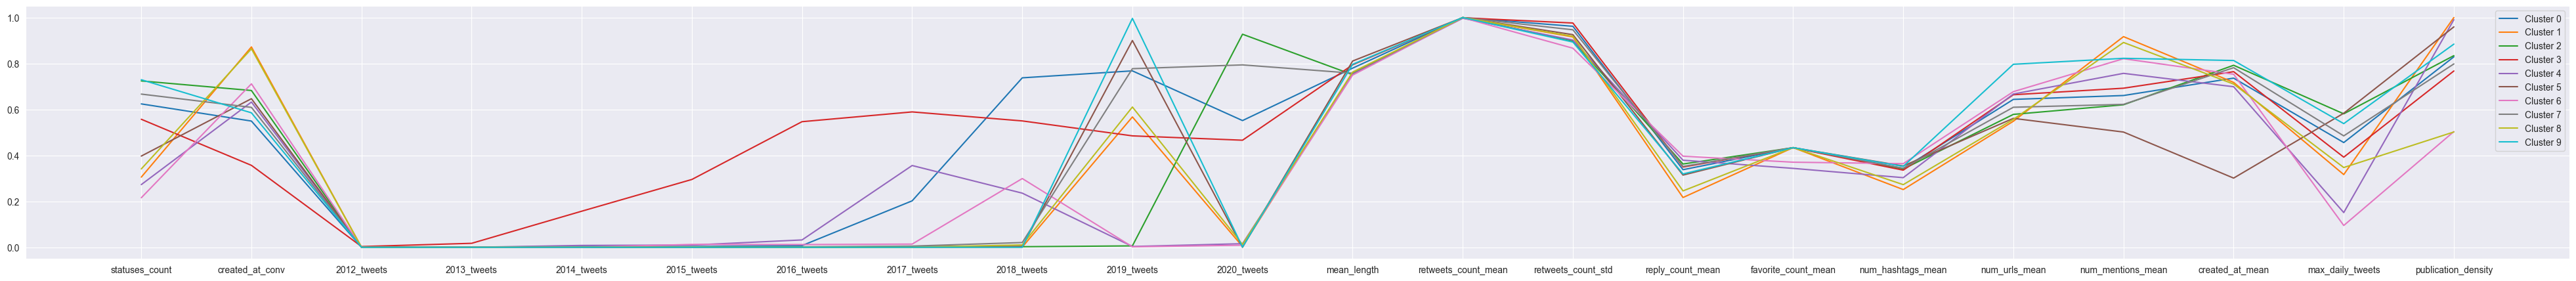

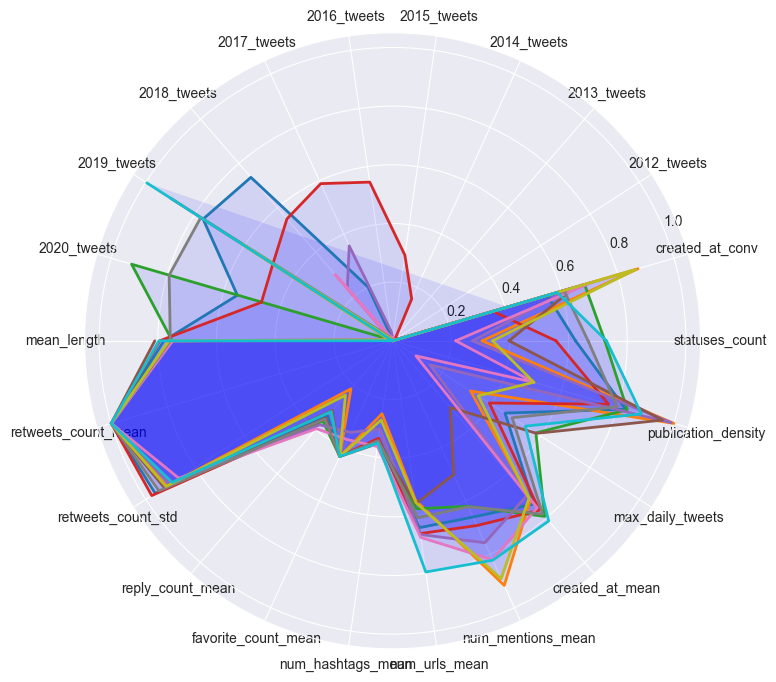

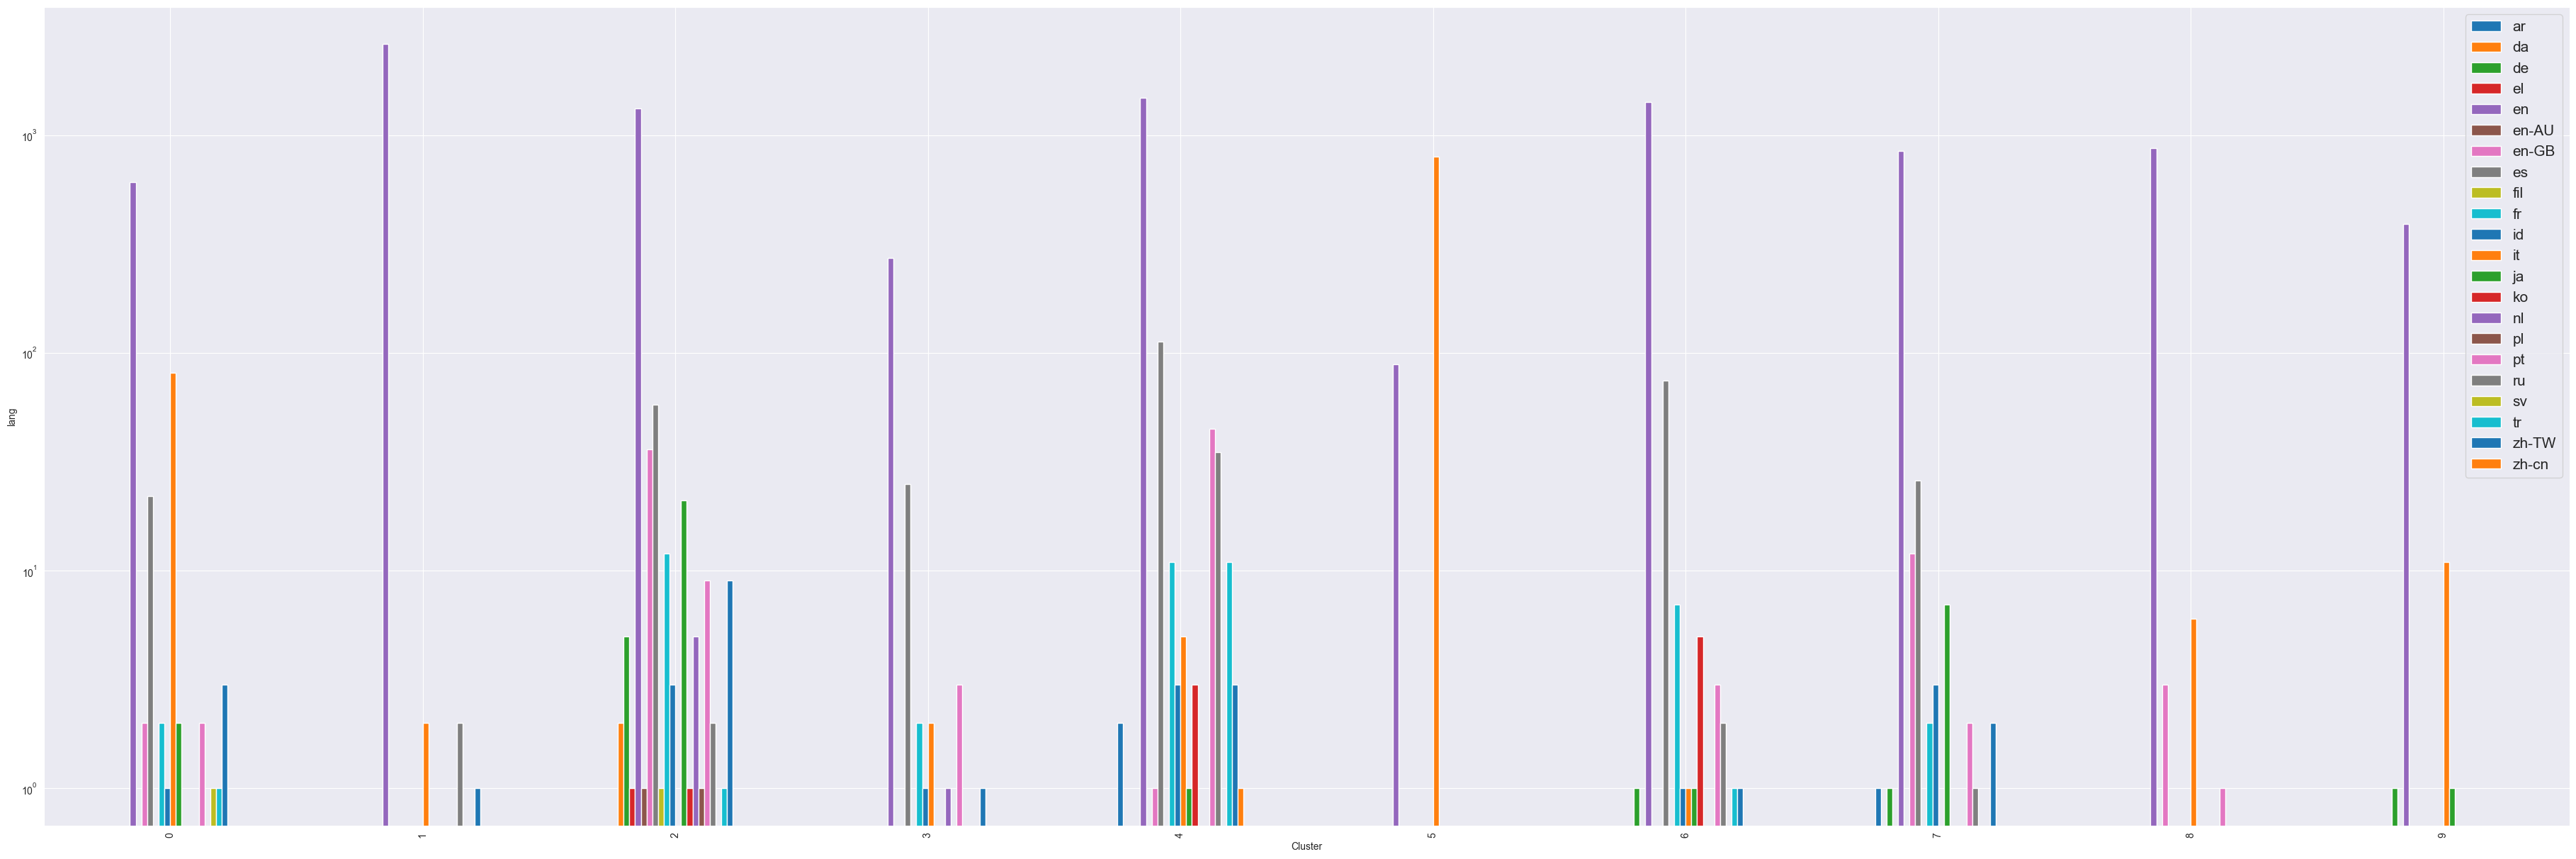

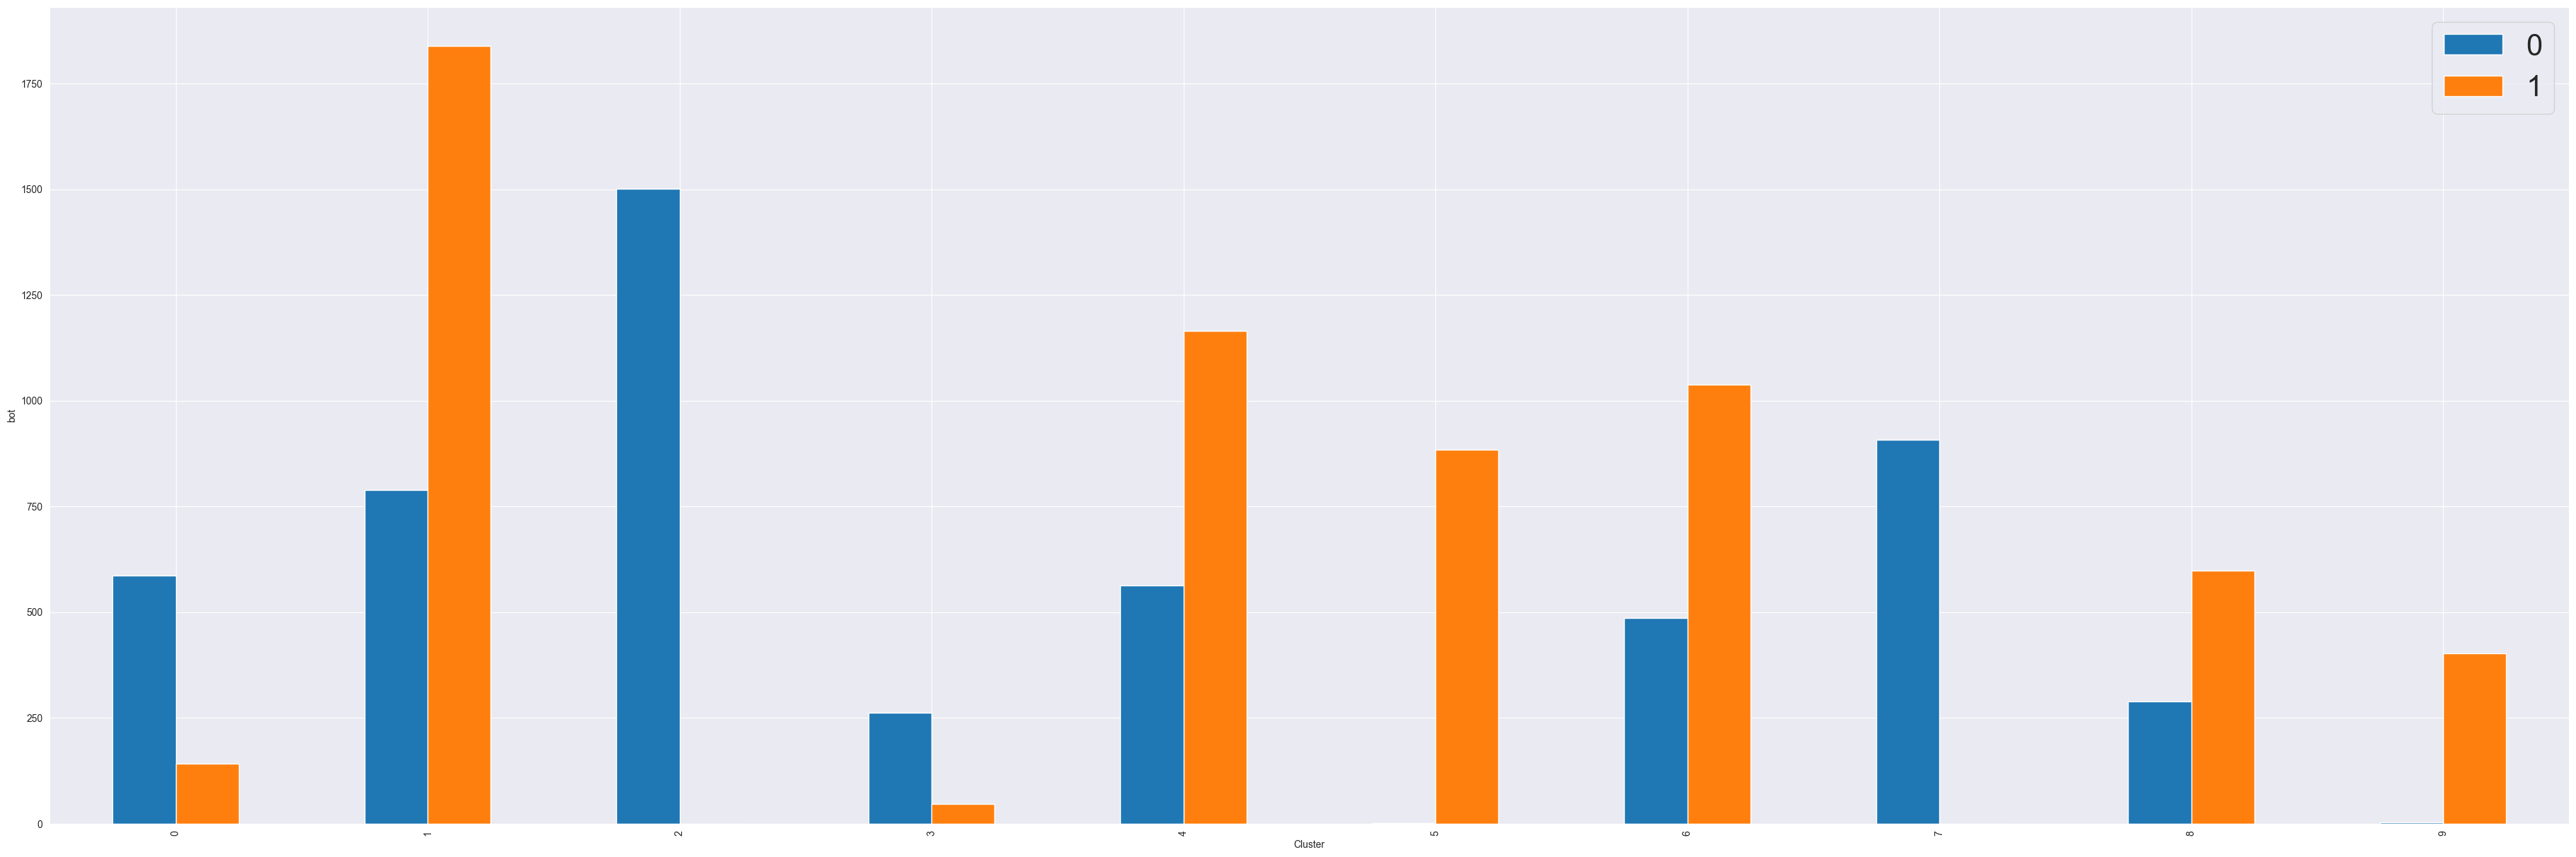

In [ ]:
kmeans_analysis(df_merge_scaled, k=10, out_dir='kmeans/scaled_k10')

In [ ]:
kmeans_analysis(df_denoised, k=7, out_dir='kmeans/denoised_k7')

In [ ]:
kmeans_analysis(df_denoised, k=8, out_dir='kmeans/denoised_k8')

In [ ]:
kmeans_analysis(df_denoised, k=9, out_dir='kmeans/denoised_k9')

In [ ]:
kmeans_analysis(df_denoised, k=10, out_dir='kmeans/denoised_k10')

# Hierarchical clustering

In [ ]:
try:
  os.mkdir('hierarchical')
except FileExistsError:
  pass

In [ ]:
df_merge_scaled[numeric_attributes].loc[[0,1,3]].mean()

In [ ]:
def hierarchical_analysis(df,metric, method, truncate_mode, p, n_clusters, directory, plot=False):
    df = df.reset_index()
    distances = pdist(df[numeric_attributes], metric=metric)
    dlinkage = linkage(distances, metric=metric, method=method)

    labels = fcluster(dlinkage,n_clusters,criterion='maxclust')
    if plot:
        try:
            os.mkdir(os.path.join('hierarchical',directory))
        except FileExistsError:
            pass

        dendrogram(dlinkage, truncate_mode=truncate_mode, p=p)
        plt.savefig(os.path.join('hierarchical',directory,"dendrogram.png"))
        plt.show()
        scatterplot(df[numeric_attributes], 'user_subscription_in_secs', 'statuses_count',c_labels=labels,filename=os.path.join('hierarchical',directory, 'scatterplot.png'))

        plots(df, labels, os.path.join('hierarchical',directory), attributes=numeric_attributes)


    #print(f"SSE: {sse(df[numeric_attributes],labels)}")
    if len(labels) > 1:
        try:
            return get_metrics(df[numeric_attributes], labels, print_out=False)
        except:
            return 0,0
    else: return 0,0

In [ ]:
def hierarchial_gs(df):
    table = PrettyTable(colums=['metric','method','truncation_mode','truncation_level','n_clustes','sse',])
    for metric in ['cityblock','correlation', 'cosine', 'dice', 'euclidean']:
        methods = ['complete','single','average','weighted']
        if metric == 'euclidean':
            methods += ['ward','median','centroid']
        for method in methods:
            for truncation_mode in [None, 'lastp','level']:
                for level in [2,3,4]:
                    for k in [7,8,9,10]:
                        metrics = hierarchical_analysis(df[numeric_attributes], metric, method, truncate_mode=truncation_mode, p=level, n_clusters=k,
                                                           directory=f'hierarchical/{metric}_{method}_{truncation_mode}_{level}_{k}')
                        table.add_row([metric, method, truncation_mode, level, k, *metrics])
    print(table)

This approach is tested on both noisy and denoised data.

In [ ]:
hierarchical_analysis(df_merge_scaled,'euclidean','ward','lastp',p=10,n_clusters=10,directory='euclidean_ward_k10_p4',plot=True)

In [ ]:
hierarchical_analysis(df_denoised,'correlation','complete','level',p=3,n_clusters=7,directory='denoised_correlation_k10',plot=True)

In [ ]:
hierarchical_analysis(df_denoised,'euclidean','ward','lastp',p=5,n_clusters=7,directory='denoised_ward_k7',plot=True)

# Agglomerative clustering

In [ ]:
def agglomerative_analysis(df, n_clusters, metric='euclidean', linkage='ward'):
    clusters = AgglomerativeClustering(affinity=metric, n_clusters=n_clusters, linkage=linkage)
    clusters.fit(df_merge_scaled[numeric_attributes])

    path=f'agglomerative/{metric}_{linkage}_k{n_clusters}/'
    get_metrics(df_merge_scaled[numeric_attributes], clusters.labels_)
    plots(df_merge_scaled, clusters.labels_, path=path, attributes=numeric_attributes)
    plt.show()
    scatterplot(df_merge_scaled, 'user_subscription_in_secs', 'statuses_count', clusters.labels_,filename=os.path.join(path,'scatterplot.png'))

In [ ]:
agglomerative_analysis(df_merge_scaled,10)

In [ ]:
agglomerative_analysis(df_merge_scaled,7)

# X-Means

from https://github.com/annoviko/pyclustering/

In [ ]:
try:
  os.mkdir('xmeans')
except:
  pass

In [ ]:

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

k_start = 2
clusters_start = kmeans_plusplus_initializer(df_merge_scaled[numeric_attributes], 2).initialize()
 
# By defeault max # of clusters is 20, but we set it to 10
x_means = xmeans(df_merge_scaled[numeric_attributes], clusters_start, kmax=10, repeat=300) #, initial_centers, 20)
x_means.process()
 
# Extract clustering results: clusters and their centers
clusters = x_means.get_clusters()
centroids = x_means.get_centers()

print(f'Number of clusters found:', np.shape(centroids)[0])

In [ ]:
cluster_labels = dict()

''' 
Since for each cluster is saved the index in list of data
it is needed to convert it in such a way that
we have a list as long as the data, and in each
position it is saved the corresponding label for the
data with that index
'''
for label in range(0, np.shape(clusters)[0]):
  for i in range(0, len(clusters[label])):
    cluster_labels[clusters[label][i]] = label

cluster_labels = dict(sorted(cluster_labels.items()))

In [ ]:
print("SSE:", x_means.get_total_wce())
get_metrics(df_merge_scaled[numeric_attributes], list(cluster_labels.values()))

In [ ]:
plots(df_merge_scaled, np.array(list(cluster_labels.values())), path='xmeans', centroids=np.array(centroids), attributes = numeric_attributes)